# QCCS: This program is a simple algorithm for finding the most optimum thresholds by optimizing rotation coefficients and QA sample delay

## This will run 128 measurements of a qubit each in ground and excited state.

### Table of Contents

* [1) Imports and helper functions](#chapter1)
* [2) Device initialization/connection](#chapter2)
* [3) Configure PQSC](#chapter3)
* [4) Configure HDAWG](#chapter4)
* [5) Configure UHFQA](#chapter5)
    * [5.2 Configure UHFQA QCCS mode](#section_5_1)
    * [5.2 Configure UHFQA for 2-qubit](#section_5_2)
* [6) Initialise and upload UHF/HD AWG programs](#chapter6)
* [7) Configure Upload and Run program](#chapter7)
* [8) Read results (under work)](#chapter8)

### 1) Imports and helper functions <a class="anchor" id="chapter1"></a>

In [1]:
import time
import zhinst.ziPython as zi
import numpy as np
import matplotlib.pyplot as plt
import math

# Compile AWG seqC code
def awg_compile_upload_elf(awgModule, awgIndex, awg_program):
    """Compile and upload awg_program as .elf file"""
    awgModule.set('awgModule/index', awgIndex)
    awgModule.set('awgModule/compiler/sourcestring', awg_program)

    while awgModule.getInt('awgModule/compiler/status') == -1:
        time.sleep(0.1)
    if awgModule.getInt('awgModule/compiler/status') == 1:
        raise Exception(awgModule.getString('awgModule/compiler/statusstring'))

    if awgModule.getInt('awgModule/compiler/status') == 2:
        print("Compilation successful with warnings, will upload the program to the instrument.")
        print("Compiler warning: ", awgModule.getString('awgModule/compiler/statusstring'))

    time.sleep(0.2)
    i = 0
    while (awgModule.getDouble('awgModule/progress') < 1.0) and (awgModule.getInt('awgModule/elf/status') != 1):
        time.sleep(0.5)
        i += 1

    if awgModule.getInt('awgModule/elf/status') == 1:
        raise Exception("Upload to the instrument failed.")
        
# Rotation in I/Q plane
def rotate(number, degree):
    n = number
    return (math.e**(math.radians(degree)*1j)) * n

### 2) Specify your data server + devices used <a class="anchor" id="chapter2"></a>
#### Note: variable UHFQA_watch can be ignored

In [2]:
SERVER = '127.0.0.1'

daq = zi.ziDAQServer(SERVER, 8004, 1)

# Define device IDs
PQSC = 'dev10006'
UHFQA = 'dev2171'
HDAWG = 'dev8147'

# On the continuity setup, this device is not connected to anything or perform any function
UHFQA_watch = 'dev2004' 


# Connection to data server
daq.connectDevice(PQSC, '1gbe')
daq.connectDevice(UHFQA, '1gbe')
daq.connectDevice(HDAWG, '1gbe')

### 3) Configure the PQSC for register forwarding (conditional unit TBD)  <a class="anchor" id="chapter3"></a>

In [3]:
### Configure PQSC

# Use external reference clock coming from the UHFQA
daq.setInt(f'/{PQSC}/system/clocks/referenceclock/in/source', 1)

## Configure execution engine
# Send a single trigger to start the HDAWG and the UHFQA
daq.setInt(f'/{PQSC}/execution/repetitions', 1)
# Wait for feedback to arrive from UHFQA (10us is more than enough)
daq.setDouble(f'/{PQSC}/execution/holdoff', 10e-6)

## Register forwarding
# ZSync output port to the receiver HDAWG
port = 0
# Program register bank forwarding
fwd_length = 4
fwd = range(0, 4)
daq.setVector(f'/{PQSC}/raw/regs/{port}/fwd', np.array(fwd).astype(np.uint32))
# Enable forwarding on output port
daq.setInt(f'/{PQSC}/raw/zsyncs/{port}/txmux/fwd_en', 1)

## Condition unit
# ZSync output port to the receiver HDAWG
port = 0
# Program condition unit sources
src_length = 8
src = range(0, 8)
daq.setVector(f'/{PQSC}/raw/cond/src', np.array(src).astype(np.uint32))
# Program condition unit function
lut_length = 2**src_length
offset = 512
lut = range(offset, offset+lut_length)
daq.setVector(f'/{PQSC}/raw/cond/lut', np.array(lut).astype(np.uint32))
# Program condition unit byte selection
sel_length = 18
sel = [1] * sel_length
daq.setVector(f'/{PQSC}/raw/cond/sel', np.array(sel).astype(np.uint32))

# Enable condition output on forwarding port
daq.setInt(f'/{PQSC}/raw/zsyncs/{port}/txmux/cond_en', 0) # This should be 0 according to Niels, cond not working

### 4) Configure HDAWG to QCCS mode  <a class="anchor" id="chapter4"></a>

In [4]:
## Configure HDAWG

# Use ZSync clock
daq.setInt(f'/{HDAWG}/system/clocks/referenceclock/source', 2)

## Configure DIO
# Configure DIO switch to QCCS mode
daq.setInt(f'/{HDAWG}/dios/0/mode', 3)
# Drive the two most significant bytes of the DIO port
# The UHFQA drives the two least significant bytes of the DIO port
daq.setInt(f'/{HDAWG}/dios/0/drive', 0b1100)
# Configure DIO triggering to match ZSync input
daq.setInt(f'{HDAWG}/awgs/0/dio/strobe/slope', 0)
daq.setInt(f'{HDAWG}/awgs/0/dio/valid/polarity', 0)

## Configure AWG
# Setup AWG module
awg_hd = daq.awgModule()
awg_hd.set('device', HDAWG)
awg_hd.set('index', 0)
awg_hd.execute()

# Turn on HDAWG outputs
daq.setInt(f'/{HDAWG}/sigouts/0/on', 1)
daq.setInt(f'/{HDAWG}/sigouts/1/on', 1)

### 5) Configure UHFQA <a class="anchor" id="chapter5"></a>

### 5.1) Configure UHFQA for QCCS mode <a class="anchor" id="section_5_1"></a>

In [5]:
### Configure UHFQA

# UHFQA uses its own clock in this experiment

## Configure DIO
# Sample DIO data at 50 MHz
daq.setInt(f'{UHFQA}/dios/0/extclk', 2)
# Set DIO output to QA result QCCS
daq.setInt(f'{UHFQA}/dios/0/mode', 4)
# Drive the two least significant bytes of the DIO port
# The HDAWG drives the two most significant bytes of the DIO port
daq.setInt(f'{UHFQA}/dios/0/drive', 0b0011)
# Configure DIO triggering to match HDAWG DIO input
daq.setInt(f'/{UHFQA}/awgs/0/dio/strobe/slope', 0)
daq.setInt(f'/{UHFQA}/awgs/0/dio/valid/polarity', 2)
daq.setInt(f'/{UHFQA}/awgs/0/dio/valid/index', 16)

## QA readout configuration
# Bypass crosstalk to reduce latency
daq.setInt(f'{UHFQA}/qas/0/crosstalk/bypass', 1)
# Set length of integration (arbitrary value of 128)
daq.setInt(f'{UHFQA}/qas/0/integration/length', 128)
# Set threshold levels to a low value so qubit readout is always high
for i in range(10):
    daq.setDouble(f'/{UHFQA}/qas/0/thresholds/{i}/level', -100)
# Reset QA results
daq.setInt(f'{UHFQA}/qas/0/result/reset', 1)

### 5.2) Configure UHFQA for two-qubit readout + upload integration weights <a class="anchor" id="section_5_2"></a>

In [6]:
# Input/Output settings
daq.setInt(f'/{UHFQA}/sigins/0/imp50', 1)
daq.setInt(f'/{UHFQA}/sigins/1/imp50', 1)
daq.setDouble(f'/{UHFQA}/sigins/0/range', 1.5)
daq.setDouble(f'/{UHFQA}/sigins/1/range', 1.5)
daq.setInt(f'/{UHFQA}/sigouts/0/on', 1)
daq.setInt(f'/{UHFQA}/sigouts/1/on', 1)


# Configure QA setup
### Sample delay begins at 0: Find the delay present from signal output to QA integrator input
daq.setInt(f'/{UHFQA}/qas/0/delay', 0) # JS: 
# Integration length chosen 128 since the signal to be read and integrated is exactly 128 samples long
daq.setDouble(f'/{UHFQA}/qas/0/integration/length', 128) # JS: Does reducing the length = less time used for integration? Probably not
daq.setInt(f'/{UHFQA}/qas/0/integration/mode', 0)
daq.setInt(f'/{UHFQA}/qas/0/integration/sources/0', 0)
daq.setInt(f'/{UHFQA}/qas/0/integration/sources/1', 0)

daq.setDouble(f'/{UHFQA}/qas/0/result/length', 128)

# Set QA result mode to "Integration" mode in I/Q plane
daq.setInt(f'/{UHFQA}/qas/0/result/source', 7)


# Upload integration weights
ch1_freq = 28.125e6 # Oscillator frequency
ch2_freq = 56.25e6 # Oscillator frequency
fs_uhfqa = 1.8e9 # Sampling frequency of UHF-QA
integrationPoints = 4096 # Number of sampled used for integration
ampl = 0.38 # Vpk of weights signal

ch1_w_real = ampl*np.sin(2*np.pi*ch1_freq*np.arange(integrationPoints)/fs_uhfqa)
ch1_w_imag = ampl*np.cos(2*np.pi*ch1_freq*np.arange(integrationPoints)/fs_uhfqa)

ch2_w_real = ampl*np.sin(2*np.pi*ch2_freq*np.arange(integrationPoints)/fs_uhfqa)
ch2_w_imag = ampl*np.cos(2*np.pi*ch2_freq*np.arange(integrationPoints)/fs_uhfqa)

daq.setVector(f'/{UHFQA}/qas/0/integration/weights/0/real', ch1_w_real)
daq.setVector(f'/{UHFQA}/qas/0/integration/weights/0/imag', ch1_w_imag)

daq.setVector(f'/{UHFQA}/qas/0/integration/weights/1/real', ch2_w_real)
daq.setVector(f'/{UHFQA}/qas/0/integration/weights/1/imag', ch2_w_imag)

### 6) Compile & upload AWG programs and start the program for four repetitions
## Note: The UHF-AWG is looped for 128 times - HD-AWG is looped for 64 times with two DIO triggers each loop
## In total: PQSC will send out 128 triggers which should finish both the programs.
<a class="anchor" id="chapter6"></a>

In [7]:
UHF_qubitSim_prog = '''
const ampl = 0.5;
 
wave I_q0_state_0 = zeros(128);
wave Q_q0_state_0 = zeros(128);
wave I_q0_state_1 = sine(128, ampl, 0, 2);
wave Q_q0_state_1 = cosine(128, ampl, 0, 2);
 
wave I_q1_state_0 = zeros(128);
wave Q_q1_state_0 = zeros(128);
wave I_q1_state_1 = sine(128, ampl, 0, 4);
wave Q_q1_state_1 = cosine(128, ampl, 0, 4);
 
wave I_state_00 = I_q1_state_0 + I_q0_state_0;
wave Q_state_00 = Q_q1_state_0 + Q_q0_state_0;
 
wave I_state_01 = I_q1_state_0 + I_q0_state_1;
wave Q_state_01 = Q_q1_state_0 + Q_q0_state_1;
 
wave I_state_10 = I_q1_state_1 + I_q0_state_0;
wave Q_state_10 = Q_q1_state_1 + Q_q0_state_0;
 
wave I_state_11 = I_q1_state_1 + I_q0_state_1;
wave Q_state_11 = Q_q1_state_1 + Q_q0_state_1;

var qubitState = getUserReg(0); 

repeat(128){
waitDIOTrigger();
setID(0);



switch (qubitState) {
  case 0: playWave(I_state_00, Q_state_00);startQAResult(0x300 << 16, 0b1111);waitQAResultTrigger();
  case 1: playWave(I_state_01, Q_state_01);startQAResult(0x300 << 16, 0b1111);waitQAResultTrigger();
  case 2: playWave(I_state_10, Q_state_10);startQAResult(0x300 << 16, 0b1111);waitQAResultTrigger();
  case 3: playWave(I_state_11, Q_state_11);startQAResult(0x300 << 16, 0b1111);waitQAResultTrigger();
}
}
'''

HD_rstpulse_prog = '''
setUserReg(0,0);
setUserReg(1,0);
setUserReg(2,0);
setUserReg(3,0);

repeat(64){
// At start of program
waitDIOTrigger();
// Wait for qubit measurement result
waitDIOTrigger();
var res = getDIOTriggered();

}

'''

# Channels to test
channels = [0,1]

# Setup UHF AWG module
awg_uhf = daq.awgModule()
awg_uhf.set('device', UHFQA)
awg_uhf.set('index', 0)
awg_uhf.execute()
awg_uhf.set('awg/enable', 0)

# Setup HD AWG module
awg_hd = daq.awgModule()
awg_hd.set('device', HDAWG)
awg_hd.set('index', 0)
awg_hd.execute()
awg_hd.set('awg/enable', 0)

# Upload HD program
awg_compile_upload_elf(awg_uhf, 0, UHF_qubitSim_prog)

# Upload UHF program
awg_compile_upload_elf(awg_hd, 0, HD_rstpulse_prog)

# PQSC holdoff time in seconds (must be multiple of 10)
daq.setDouble(f'/{PQSC}/execution/repetitions', 128)
daq.setDouble(f'/{PQSC}/execution/holdoff', 100e-3)

### 7) Run each of the four possible qubit states 128 times
#### Rotate the resulting complex result 360* and find the maximum real value
#### The maximum real value along with the corresponding angle rotation will be stored for each state
<a class="anchor" id="chapter6"></a>

### 7.1) Find qubit 1 and qubit 2 ground state threshold: 00  <a class="anchor" id="chapter7"></a>

In [8]:
for ch in channels:
    daq.setDouble('/{:s}/qas/0/thresholds/{:d}/level'.format(UHFQA, ch), 0)

# 0 --> both qubits are in ground state
daq.setInt(f'/{UHFQA}/AWGS/0/USERREGS/0', 0)
    
# Now we're ready for readout. Enable result unit and start acquisition.
daq.setInt('/{:s}/qas/0/result/reset'.format(UHFQA), 1)
daq.setInt('/{:s}/qas/0/result/enable'.format(UHFQA), 1)
daq.sync()
#
# Subscribe to result waves
paths = []
for ch in channels:
    path = '/{:s}/qas/0/result/data/{:d}/wave'.format(UHFQA, ch)
    paths.append(path)
daq.subscribe(paths)

# Arm the device
daq.asyncSetInt('/{:s}/awgs/0/single'.format(UHFQA), 1)
daq.syncSetInt('/{:s}/awgs/0/enable'.format(UHFQA), 1)

time.sleep(2)

daq.asyncSetInt(f'/{PQSC}/execution/enable', 1)

# Perform acquisition
print('Acquiring data...')
# Since we are acquiring 128 data samples (maybe over-doing it, but reliable), and each PQSC trigger is 100 ms
# We will need to poll for at least 128*100ms = 12.8 seconds, so below I chose 20 seconds just to be safe.
data = daq.poll(20, 20000, 4, True)
#data = acquisition_poll(daq, paths, result_length)
print('Done.')

# Stop result unit
daq.unsubscribe(paths)
daq.setInt('/{:s}/qas/0/result/enable'.format(UHFQA), 0)

avgCh1 = np.average(data[paths[0]][0]['vector'])
avgCh2 = np.average(data[paths[1]][0]['vector'])

Acquiring data...
Done.


Optimum rotation found at a rotation of 229 degrees which gives a real value for qubit 1 ground state at 0.002367931188146823
Optimum rotation found at a rotation of 222 degrees which gives a real value for qubit 2 ground state at 0.00035690125467061496


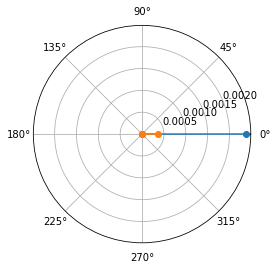

In [9]:
maxVal = avgCh1
for i in range(0, 365):
    tempVal = rotate(avgCh1, i)
    
    if(np.real(tempVal) > np.real(maxVal)):
        maxVal = tempVal
        rotDegrees = i

plt.polar([0,np.angle(maxVal)],[0,abs(maxVal)],marker='o')
print(f'Optimum rotation found at a rotation of {rotDegrees} degrees which gives a real value for qubit 1 ground state at {np.real(maxVal)}')        
    
# Stores maximum value of qubit 1 when 00
ch0_00 = maxVal
ch0_00_rot = rotDegrees

maxVal = avgCh2
for i in range(0, 365):
    tempVal = rotate(avgCh2, i)
    
    if(np.real(tempVal) > np.real(maxVal)):
        maxVal = tempVal
        rotDegrees = i
        
plt.polar([0,np.angle(maxVal)],[0,abs(maxVal)],marker='o')
print(f'Optimum rotation found at a rotation of {rotDegrees} degrees which gives a real value for qubit 2 ground state at {np.real(maxVal)}')

# Stores maximum value of qubit 2 when 00
ch1_00 = maxVal
ch1_00_rot = rotDegrees

### 7.2) Find qubit 1 and qubit 2 excited state threshold : 11 <a class="anchor" id="chapter7"></a>

In [10]:
for ch in channels:
    daq.setDouble('/{:s}/qas/0/thresholds/{:d}/level'.format(UHFQA, ch), 0)

# 0 --> both qubits are in excited state
daq.setInt(f'/{UHFQA}/AWGS/0/USERREGS/0', 3)
    
# Now we're ready for readout. Enable result unit and start acquisition.
daq.setInt('/{:s}/qas/0/result/reset'.format(UHFQA), 1)
daq.setInt('/{:s}/qas/0/result/enable'.format(UHFQA), 1)
daq.sync()
#
# Subscribe to result waves
paths = []
for ch in channels:
    path = '/{:s}/qas/0/result/data/{:d}/wave'.format(UHFQA, ch)
    paths.append(path)
daq.subscribe(paths)
#
# Arm the device
daq.asyncSetInt('/{:s}/awgs/0/single'.format(UHFQA), 1)
daq.syncSetInt('/{:s}/awgs/0/enable'.format(UHFQA), 1)

daq.setInt(f'/{PQSC}/execution/enable', 1)

# Perform acquisition
print('Acquiring data...')
# Since we are acquiring 128 data samples (maybe over-doing it, but reliable), and each PQSC trigger is 100 ms
# We will need to poll for at least 128*100ms = 12.8 seconds, so below I chose 20 seconds just to be safe.
data = daq.poll(20, 20000, 4, True)
#data = acquisition_poll(daq, paths, result_length)
print('Done.')

# Stop result unit
daq.unsubscribe(paths)
daq.setInt('/{:s}/qas/0/result/enable'.format(UHFQA), 0)

avgCh1 = np.average(data[paths[0]][0]['vector'])
avgCh2 = np.average(data[paths[1]][0]['vector'])

Acquiring data...
Done.


Optimum rotation found at a rotation of 317 degrees which gives a real value for qubit 1 excited state at 6.662619511220351
Optimum rotation found at a rotation of 317 degrees which gives a real value for qubit 2 excited state at 6.229995711882447


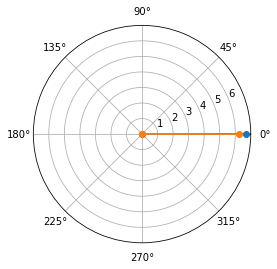

In [11]:
maxVal = avgCh1
for i in range(0, 365):
    tempVal = rotate(avgCh1, i)
    
    if(np.real(tempVal) > np.real(maxVal)):
        maxVal = tempVal
        rotDegrees = i

plt.polar([0,np.angle(maxVal)],[0,abs(maxVal)],marker='o')
print(f'Optimum rotation found at a rotation of {rotDegrees} degrees which gives a real value for qubit 1 excited state at {np.real(maxVal)}')        
        
# Stores maximum value of qubit 1 when 11
ch0_11 = maxVal
ch0_11_rot = rotDegrees


maxVal = avgCh2
for i in range(0, 365):
    tempVal = rotate(avgCh2, i)
    
    if(np.real(tempVal) > np.real(maxVal)):
        maxVal = tempVal
        rotDegrees = i
        
plt.polar([0,np.angle(maxVal)],[0,abs(maxVal)],marker='o')
print(f'Optimum rotation found at a rotation of {rotDegrees} degrees which gives a real value for qubit 2 excited state at {np.real(maxVal)}')

# Stores maximum value of qubit 1 when 11
ch1_11 = maxVal
ch1_11_rot = rotDegrees

### 7.3) Find qubit 1 excited state threshold: 01  <a class="anchor" id="chapter7"></a>

In [12]:
for ch in channels:
    daq.setDouble('/{:s}/qas/0/thresholds/{:d}/level'.format(UHFQA, ch), 0)

# 0 --> both qubits are in excited state
daq.setInt(f'/{UHFQA}/AWGS/0/USERREGS/0', 1)
    
# Now we're ready for readout. Enable result unit and start acquisition.
daq.setInt('/{:s}/qas/0/result/reset'.format(UHFQA), 1)
daq.setInt('/{:s}/qas/0/result/enable'.format(UHFQA), 1)
daq.sync()
#
# Subscribe to result waves
paths = []
for ch in channels:
    path = '/{:s}/qas/0/result/data/{:d}/wave'.format(UHFQA, ch)
    paths.append(path)
daq.subscribe(paths)
#
# Arm the device
daq.asyncSetInt('/{:s}/awgs/0/single'.format(UHFQA), 1)
daq.syncSetInt('/{:s}/awgs/0/enable'.format(UHFQA), 1)

daq.setInt(f'/{PQSC}/execution/enable', 1)

# Perform acquisition
print('Acquiring data...')
# Since we are acquiring 128 data samples (maybe over-doing it, but reliable), and each PQSC trigger is 100 ms
# We will need to poll for at least 128*100ms = 12.8 seconds, so below I chose 20 seconds just to be safe.
data = daq.poll(20, 20000, 4, True)
#data = acquisition_poll(daq, paths, result_length)
print('Done.')

# Stop result unit
daq.unsubscribe(paths)
daq.setInt('/{:s}/qas/0/result/enable'.format(UHFQA), 0)

avgCh1 = np.average(data[paths[0]][0]['vector'])
avgCh2 = np.average(data[paths[1]][0]['vector'])

Acquiring data...
Done.


Optimum rotation found at a rotation of 316 degrees which gives a real value for qubit 1 excited state at 6.780792667912355
Optimum rotation found at a rotation of 86 degrees which gives a real value for qubit 2 ground state at 0.1457076984477823


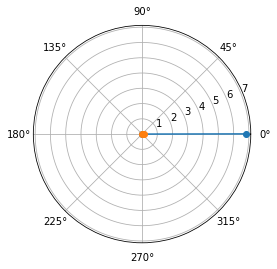

In [13]:
maxVal = avgCh1
for i in range(0, 365):
    tempVal = rotate(avgCh1, i)
    
    if(np.real(tempVal) > np.real(maxVal)):
        maxVal = tempVal
        rotDegrees = i

plt.polar([0,np.angle(maxVal)],[0,abs(maxVal)],marker='o')
print(f'Optimum rotation found at a rotation of {rotDegrees} degrees which gives a real value for qubit 1 excited state at {np.real(maxVal)}')        

# Stores maximum value of qubit 1 when 01
ch0_01 = maxVal
ch0_01_rot = rotDegrees


maxVal = avgCh2
for i in range(0, 365):
    tempVal = rotate(avgCh2, i)
    
    if(np.real(tempVal) > np.real(maxVal)):
        maxVal = tempVal
        rotDegrees = i
        
plt.polar([0,np.angle(maxVal)],[0,abs(maxVal)],marker='o')
print(f'Optimum rotation found at a rotation of {rotDegrees} degrees which gives a real value for qubit 2 ground state at {np.real(maxVal)}')

# Stores maximum value of qubit 2 when 01
ch1_01 = maxVal
ch1_01_rot = rotDegrees

### 7.4) Find qubit 2 excited state threshold:10  <a class="anchor" id="chapter7"></a>

In [14]:
for ch in channels:
    daq.setDouble('/{:s}/qas/0/thresholds/{:d}/level'.format(UHFQA, ch), 0)

# 0 --> both qubits are in excited state
daq.setInt(f'/{UHFQA}/AWGS/0/USERREGS/0', 2)
    
# Now we're ready for readout. Enable result unit and start acquisition.
daq.setInt('/{:s}/qas/0/result/reset'.format(UHFQA), 1)
daq.setInt('/{:s}/qas/0/result/enable'.format(UHFQA), 1)
daq.sync()
#
# Subscribe to result waves
paths = []
for ch in channels:
    path = '/{:s}/qas/0/result/data/{:d}/wave'.format(UHFQA, ch)
    paths.append(path)
daq.subscribe(paths)
#
# Arm the device
daq.asyncSetInt('/{:s}/awgs/0/single'.format(UHFQA), 1)
daq.syncSetInt('/{:s}/awgs/0/enable'.format(UHFQA), 1)

daq.setInt(f'/{PQSC}/execution/enable', 1)

# Perform acquisition
print('Acquiring data...')
# Since we are acquiring 128 data samples (maybe over-doing it, but reliable), and each PQSC trigger is 100 ms
# We will need to poll for at least 128*100ms = 12.8 seconds, so below I chose 20 seconds just to be safe.
data = daq.poll(20, 20000, 4, True)
#data = acquisition_poll(daq, paths, result_length)
print('Done.')

# Stop result unit
daq.unsubscribe(paths)
daq.setInt('/{:s}/qas/0/result/enable'.format(UHFQA), 0)

avgCh1 = np.average(data[paths[0]][0]['vector'])
avgCh2 = np.average(data[paths[1]][0]['vector'])

Acquiring data...
Done.


Optimum rotation found at a rotation of 86 degrees which gives a real value for qubit 1 ground state at 0.14020886194239507
Optimum rotation found at a rotation of 316 degrees which gives a real value for qubit 2 excited state at 6.346715273433425


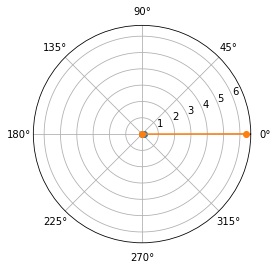

In [15]:
maxVal = avgCh1
for i in range(0, 365):
    tempVal = rotate(avgCh1, i)
    
    if(np.real(tempVal) > np.real(maxVal)):
        maxVal = tempVal
        rotDegrees = i

plt.polar([0,np.angle(maxVal)],[0,abs(maxVal)],marker='o')
print(f'Optimum rotation found at a rotation of {rotDegrees} degrees which gives a real value for qubit 1 ground state at {np.real(maxVal)}')        

# Stores maximum value of qubit 1 when 01
ch0_10 = maxVal
ch0_10_rot = i


maxVal = avgCh2
for i in range(0, 365):
    tempVal = rotate(avgCh2, i)
    
    if(np.real(tempVal) > np.real(maxVal)):
        maxVal = tempVal
        rotDegrees = i
        
plt.polar([0,np.angle(maxVal)],[0,abs(maxVal)],marker='o')
print(f'Optimum rotation found at a rotation of {rotDegrees} degrees which gives a real value for qubit 2 excited state at {np.real(maxVal)}')

# Stores maximum value of qubit 2 when 01
ch1_10 = maxVal
ch1_10_rot = rotDegrees

In [16]:
# Channel 1 and 2 rotated values

ch0rot = (ch0_01_rot + ch0_11_rot)/2

ch1rot = (ch1_10_rot + ch1_11_rot)/2

print(f'{ch0rot}')
print(f'{ch1rot}')

# Find rotation co-efficients
ch0rot = complex(np.cos(math.radians(ch0rot)), np.sin(math.radians(ch0rot)))
ch1rot = complex(np.cos(math.radians(ch1rot)), np.sin(math.radians(ch1rot)))

# Find threshold for channels 0 and 1
ch0_threshold = (np.real(ch0_01) - np.real(ch0_00))/2
ch1_threshold = (np.real(ch1_10) - np.real(ch1_00))/2


print(f'{ch0_threshold}')
print(f'{ch1_threshold}')

# Set the optimum rotations for channels 0 and 1
daq.setComplex(f'/{UHFQA}/qas/0/rotations/0', ch0rot)
daq.setComplex(f'/{UHFQA}/qas/0/rotations/1', ch1rot)

# Set the optimum thresholds for channels 0 and 1
daq.setDouble(f'/{UHFQA}/qas/0/thresholds/0/level', ch0_threshold)
daq.setDouble(f'/{UHFQA}/qas/0/thresholds/1/level', ch1_threshold)

316.5
316.5
3.389212368362104
3.173179186089377
